In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [52]:
wi_training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')
ma_training = pd.read_csv('data/Massachusetts/train_test_split/training.csv')
ga_training = pd.read_pickle('data/GA_pickled/training.pkl')
nc_training = pd.read_csv('data/North_Carolina/train_test_split/training.csv')

In [53]:
features = list(wi_training.columns[9:])
relevantcolumns = ['COUNTY','PERCENT_3_OR_ABOVE']+features
len(relevantcolumns)

19

In [54]:
ga_training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'},inplace=True)

In [55]:
nc_training.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [56]:
wi_training=wi_training[relevantcolumns]
ma_training=ma_training[relevantcolumns]
ga_training=ga_training[relevantcolumns]
nc_training=nc_training[relevantcolumns]

In [57]:
nc_training=nc_training[nc_training['PERCENT_3_OR_ABOVE'] != '*']

In [58]:
nc_training=nc_training.dropna()

In [59]:
training = pd.concat([wi_training,ma_training,ga_training,nc_training],axis=0)

In [60]:
training = training.apply(pd.to_numeric, errors='coerce')

In [61]:
training

,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,NaN,58.508604,65586.0,52266.0,102.934660,49.119866,54.126134,149.798787,93.728419,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
1,NaN,42.187500,16631.0,42307.0,93.067423,37.142154,30.704517,165.243556,91.579850,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
2,NaN,59.333333,23688.0,49996.0,96.378027,36.954639,42.626467,159.078732,94.292621,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
3,NaN,75.934136,90998.0,83681.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
4,NaN,68.906752,91613.0,86875.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,70.000000,19383.0,54915.0,137.926921,28.720862,37.577446,183.704575,137.926921,30033.8,5018.6,1433.2,24107.2,30033.8,6650.8,178.2,814.4,6481.0,6650.8
224,NaN,69.512195,33046.0,48333.0,131.307585,38.818306,40.054315,178.329454,131.307585,30916.8,6888.4,2391.2,24107.2,30916.8,6860.6,910.4,1802.2,6481.0,6860.6
227,NaN,65.241295,227214.0,49313.0,91.741941,29.883256,24.596159,183.714823,91.741941,22496.4,15354.6,872.0,24885.2,22496.4,6242.6,1207.8,524.6,6909.0,6242.6
228,NaN,56.060606,99799.0,40777.0,129.024685,33.206873,39.224774,197.321227,129.024685,25475.8,4846.0,2406.8,24107.2,25475.8,5874.8,0.0,835.4,6481.0,5874.8


In [62]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

In [63]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import joblib
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

N_CORES = joblib.cpu_count(only_physical_cores=True)

In [64]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for Adaboost model
    dtree_reg = DecisionTreeRegressor(max_depth=4)

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

    ada_reg.fit(train_data[features], train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], ada_reg.predict(holdout_data[features]))
    rsquared[1, i] = ada_reg.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 1000

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for Random Foret model
    random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
    random_forest.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))

    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[4, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], full_lr.predict(holdout_data[features]))
    rsquared[4, i] = full_lr.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    

    i = i+1


[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[159]	train-rmse:4.57336	validation-rmse:11.31358
[0]	train-rmse:16.07849	validation-rmse:16.27813
[10]	train-rmse:7.82496	validation-rmse:11.26908
[20]	train-rmse:6.76132	validation-rmse:10.80602
[30]	train-rm

In [65]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Adaboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Random forest model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[1,:])}")

Baseline Avg. CV RMSE: 19.435566170780614 and STD: 0.28983035684433756
Adaboost model Avg. CV RMSE: 12.906395048789772 and STD: 0.4282853711378811
xgboost model Avg. CV RMSE: 10.699680617050998 and STD: 0.5275075418050919
Random forest model Avg. CV RMSE: 10.953117282796535 and STD: 0.4756653725105333
fullmodel Avg. CV RMSE: 14.559055991158607 and STD: 0.4282853711378811


In [66]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Adaboost Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Random forest model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")
print(f"fullmodel Avg. CV score: {np.mean(rsquared[4,:])} and STD: {np.std(rsquared[1,:])}")

Baseline Avg. CV score: -0.0039697246545322695 and STD: 0.005332962004680793
Adaboost Avg. CV score: 0.5571093080817437 and STD: 0.022415697948725076
Xgboost model Avg. CV score: 0.695064708859438 and STD: 0.028113712661615817
Random forest model Avg. CV score: 0.6807484011328917 and STD: 0.024339603398400394
fullmodel Avg. CV score: 0.43643944317214933 and STD: 0.022415697948725076


### Xgboost works the best on the combined model. But random forest is not far behind.

In [67]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [68]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[159]	train-rmse:4.57336	validation-rmse:11.31358


### Compare combined model vs WI-model on Wisconsin data

In [69]:
import joblib
from joblib import Parallel, delayed

In [70]:
## Save the xgboost model as a pickled file.

#joblib.dump(xgb_model, 'data/four_states_combined_xgboost_model.pkl')

In [71]:
wi_random_forest=joblib.load('data/WI_pickled/WI_random_forest_model.pkl')
wi_testing = pd.read_csv('data/Wisconsin/train_test_split/testing.csv')

In [72]:
print(root_mean_squared_error(random_forest.predict(wi_testing[features]),wi_testing['PERCENT_3_OR_ABOVE']))

dnew_reg = xgb.DMatrix(wi_testing[features],wi_testing['PERCENT_3_OR_ABOVE'],enable_categorical=True)
xgb_pred = xgb_model.predict(dnew_reg)
print(root_mean_squared_error(xgb_pred,wi_testing['PERCENT_3_OR_ABOVE']))

8.216673147283919
9.12972289579507


**As expected, the model designed only for Wisconsin only performs better than the model designed for four states combined.**

In [73]:
import shap

In [74]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

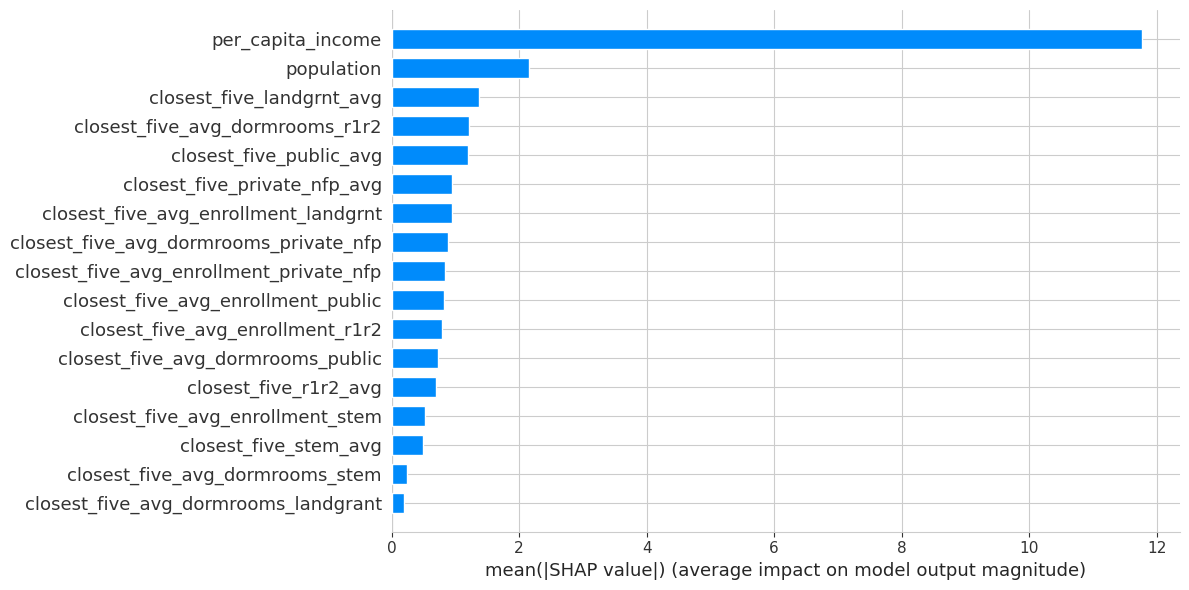

In [75]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

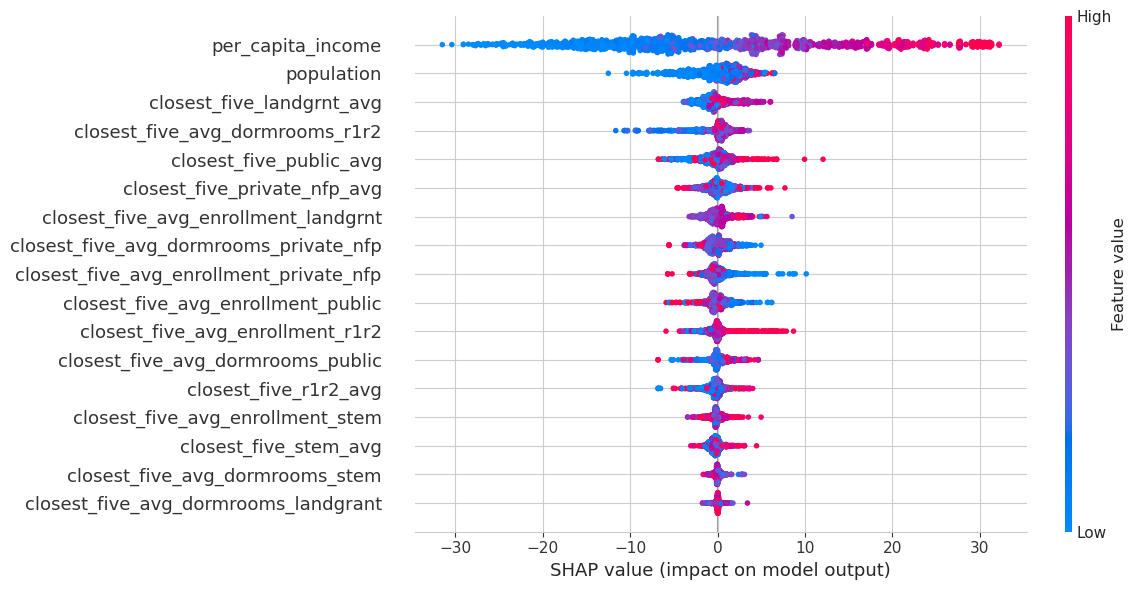

In [76]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()